In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:////etc/pihole/pihole-FTL.db')
connection = db_connect.raw_connection()
tstamp = '1600397251'
#df = pd.read_sql("SELECT * FROM queries WHERE timestamp > 1600397251", con=connection)
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
print(df.columns)

Index(['id', 'timestamp', 'type', 'status', 'domain', 'client', 'forward',
       'additional_info', 'blocked'],
      dtype='object')


In [3]:
def make_mask(x):
    y = np.zeros(50)
    y[:x] = 1
    return y

def make_multilabel(x):
    x_ = list(map(lambda xx: int(xx),x.split(' ')))
    print(x_)
    y = np.zeros(50)
    y[range(len(x_))] = x_
    return y

In [81]:
df_ = df.loc[df.client=='192.168.0.147'].reset_index()
df_['timestamp'] = df_.timestamp.round(-3)
df_dom = df_.groupby(['timestamp','domain']).count().reset_index()

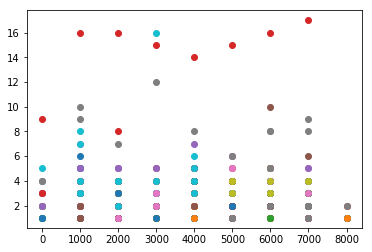

In [100]:
for dom in df_dom.domain.unique():
    df_dom_i = df_dom.loc[df_dom.domain==dom].reset_index()
    pl.plot(df_dom_i.timestamp.unique()-df_.timestamp.unique().min(),df_dom_i['index'],'o')

In [723]:
format_df = df.groupby('timestamp').sum().reset_index()
format_df['domain'] = df.groupby('timestamp')['domain'].apply(lambda x: ' '.join(x)).reset_index()['domain']
format_df['domain_list'] = df.groupby('timestamp')['domain'].apply(lambda x: ','.join(x)).reset_index()['domain']
format_df['mask_count'] = df.groupby('timestamp')['domain'].apply(lambda x: len(x)).reset_index()['domain']
format_df['domain'] = format_df['domain'].apply(lambda x: ' '.join(x.split('.')))
format_df['blocked_chain'] = df.groupby('timestamp')['blocked'].apply(lambda x: ' '.join([str(i) for i in x])).reset_index()['blocked']

In [679]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenize = Tokenizer()

In [689]:
from tensorflow.keras.layers import Embedding,Dense,Input,Flatten,Concatenate
from tensorflow.keras import Model

In [694]:
def test_model():
    input_domains = Input(shape=(2402,))
    input_mask = Input(shape=(50,))
    embed = Embedding(64,32)(input_domains)
    dense1 = Dense(32,activation='relu')(Flatten()(embed))
    
    dense_mask = Dense(32,activation='relu')(input_mask)
    concat_dense = Concatenate()([dense1,dense_mask])
    
    output = Dense(50,activation='sigmoid')(concat_dense)
    model = Model(inputs=[input_domains,input_mask],outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [695]:
tm = test_model()

In [696]:
train,test = train_test_split(range(len(encoded_docs)))

In [697]:
tm.fit([encoded_docs[train],masks[train]],labels[train],validation_data=([encoded_docs[test],masks[test]],labels[test]),epochs=5)

Train on 8376 samples, validate on 2793 samples
Epoch 1/5
8376/8376 [==============================] - 44s 5ms/sample - loss: 0.1086 - acc: 0.9515 - val_loss: 0.0233 - val_acc: 0.9951
Epoch 2/5
8376/8376 [==============================] - 45s 5ms/sample - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0109 - val_acc: 0.9962
Epoch 3/5
8376/8376 [==============================] - 44s 5ms/sample - loss: 0.0105 - acc: 0.9963 - val_loss: 0.0087 - val_acc: 0.9968
Epoch 4/5
8376/8376 [==============================] - 45s 5ms/sample - loss: 0.0083 - acc: 0.9969 - val_loss: 0.0079 - val_acc: 0.9971
Epoch 5/5
8376/8376 [==============================] - 44s 5ms/sample - loss: 0.0072 - acc: 0.9971 - val_loss: 0.0077 - val_acc: 0.9972


In [724]:
#tokenize.fit_on_texts(format_df.domain.values)
encoded_docs = tokenize.texts_to_matrix(format_df.domain.values,mode='count')

In [725]:
masks = np.array(list(map(make_mask,format_df.mask_count)))

In [726]:
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

[0]
[0, 0, 0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[1, 0]
[1, 1]
[1]
[0, 0]
[0]
[1, 1, 0]
[1]
[0]
[1, 1]
[1]
[0]
[0]
[1, 1, 0, 0]
[0, 1]
[0, 0, 0]
[0]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0]
[1, 1]
[0]
[0, 1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 1, 0, 0]
[0, 1, 0]
[0]
[0, 0, 0, 0]
[1, 1]
[1]
[1, 1, 0]
[1]
[1, 1]
[1]
[0]
[1, 1]
[1]
[0]
[1, 1]
[1, 0]
[1]
[0]
[0]
[1, 1]
[0, 1]
[0, 1, 1, 1]
[0]
[0]
[1, 1]
[1]
[1, 1]
[1, 0]
[0]
[1, 1]
[1, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[1, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1, 0]
[1, 0]
[1, 1]
[0, 1]
[0, 0]
[1]
[0, 0, 0]
[0]
[1, 1]
[1]
[1]
[0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1, 0, 1, 0, 1]
[0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1, 1, 0, 0]
[0, 1]
[0]
[0, 0, 1, 1, 1]
[0]
[0]
[0]
[0]
[0]
[1, 1, 0]
[0, 1, 0]
[0, 1, 1]
[1]
[0]
[1, 1]
[0, 1]
[0]
[0, 0, 1, 0]
[1, 0, 0]
[0, 0, 0]
[0]
[1, 1]
[1, 0]
[1, 

[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[1, 1]
[1]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0, 0]
[0]
[0, 0]
[1]
[0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0, 0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 1, 0]
[0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0, 0, 1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1, 1]
[1, 1]
[0]
[0, 0, 0]
[1, 1]
[1]
[0]
[1, 1]
[0, 0]
[1]
[0]
[1, 1]
[0]
[1]
[0]
[0, 0]
[1, 1]

[1, 1, 0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[1, 0]
[0, 0]
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[1]
[0, 1]
[1, 0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[1]
[0, 0, 1, 0, 1, 1]
[1, 0, 1]
[0, 0, 0]
[0, 0]
[0]
[0]
[0, 1]
[1, 1]
[1, 0]
[0, 0]
[0]
[0]
[0]
[1, 1, 0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[0, 1]
[0, 1, 1]
[0, 1, 0]
[0]
[0, 1]
[0]
[0]
[1, 1, 1, 1]
[1]
[0, 0]
[0]
[0, 1, 1, 1, 1]
[0]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 0, 1]
[0]
[0, 1, 0]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1, 0]
[0]
[0]
[0]
[0, 0, 0]
[0, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[1]
[0, 0]
[0]
[0, 0

[0]
[0]
[0]
[0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0]
[0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 1, 1]
[1]
[0, 0]
[0]
[1]
[1, 1]
[0]
[1]
[0]
[1, 1]
[1]
[1]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[0]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[1]
[1]
[1]
[1, 1]
[1]
[0]
[0]
[1]
[0, 1]
[1]
[0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1, 0]
[1, 1, 1, 1, 1]
[0]
[0]
[1]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0, 1]
[1]
[0]
[1]
[1]
[1]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0]
[1]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0, 0]
[0, 0]
[1, 1, 

[0]
[1]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0, 0]
[0, 0, 0]
[0]
[1, 0]
[1, 0]
[0]
[0]
[0]
[0]
[1, 1, 1]
[0]
[0]
[1]
[0, 0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0, 0]
[1, 0]
[0]
[1, 1]
[0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1]
[1]
[1, 1, 0, 0, 1, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[1, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0]
[0, 0]
[1]
[0, 0, 0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1, 1]
[0]
[1]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[1, 0, 0]
[1, 1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0]
[0]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[0]
[0, 1]
[1]
[0]
[0]
[0]
[0]
[1, 1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0]
[1]
[1, 1]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1]
[0, 0]
[0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 1, 0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0, 0]
[0, 0]
[0]
[1]
[1]
[0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[1]
[1, 0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]


In [727]:
predicted = np.where(tm.predict([encoded_docs[11169:],masks[11169:]])>0.5,1,0).astype(bool)
domain_lists = list(map(lambda x: x.split(','),format_df.domain_list.loc[11169:].values))
bad_domains = list(map(lambda x: np.array(x[0])[x[1][:len(x[0])]],zip(domain_lists,predicted)))

In [732]:
bad_domains = [i[0] for i in bad_domains if len(i)>0]

In [729]:
parsed_domain_data = df.loc[df.blocked==1].domain.unique()

In [730]:
print(len(bad_domains))
[i for i in bad_domains if i not in parsed_domain_data]

83


['imap.gmail.com',
 'apis.google.com',
 'styles.redditmedia.com',
 'ssl.gstatic.com',
 'getpocket.com',
 's.aaxads.com',
 'alb.reddit.com']

In [715]:
bad_domains

['cws-hulu.conviva.com',
 'imap.gmail.com',
 'telemetry.dropbox.com',
 'telemetry.dropbox.com',
 'apis.google.com',
 'styles.redditmedia.com',
 'js-sec.indexww.com',
 'telemetry.dropbox.com',
 'mobile.pipe.aria.microsoft.com',
 'browser.pipe.aria.microsoft.com',
 'telemetry.malwarebytes.com',
 'secure-gl.imrworldwide.com',
 'telemetry.dropbox.com',
 'ad.doubleclick.net',
 'cws-hulu.conviva.com',
 'incoming.telemetry.mozilla.org',
 'browser.pipe.aria.microsoft.com',
 'mobile.pipe.aria.microsoft.com',
 'telemetry.malwarebytes.com',
 'browser.pipe.aria.microsoft.com',
 'telemetry.dropbox.com',
 'www.googletagmanager.com',
 'cws-hulu.conviva.com',
 'mobile.pipe.aria.microsoft.com',
 'browser.pipe.aria.microsoft.com',
 'ssl.gstatic.com',
 'telemetry.malwarebytes.com',
 'incoming.telemetry.mozilla.org',
 'vortex.hulu.com',
 'ad.doubleclick.net']

In [734]:
tf.keras.models.save_model(tm,'./dns_anhilator.h5')

In [736]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [741]:
from functions import run_all

In [752]:
db_connect = create_engine('sqlite:////etc/pihole/gravity.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM gravity", con=connection)
#df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
print(df.columns)

Index(['domain', 'adlist_id'], dtype='object')


In [776]:
import time

In [777]:
time.sleep(10)